# Quality control and filtering

For a meaningful downstream analysis, it is necessary to distinguish empty and low quality
droplets/wells from bona fide cells. This can be achieved by investigating the number of detected
UMIs and genes per cell, as well as the fraction of mitochondrial reads. A low number of genes
and counts per cell can indicate empty droplets or microwells, respectively. A high fraction of
mitochondrial reads, on the other hand, may indicate ruptured cells that lost most of their cyto-
plasmic RNA having retained only their mitochondria [7, 75]. The metrics need to be considered
jointly, as a high mitochondrial content per se could also be indicative of respiratory processes
being upregulated in the cell, conveying a meaningful biological signal. Appropriate cutoffs are
commonly determined by plotting the distributions of the quality metrics across all cells in a
sample or dataset, and visually determining breakpoints between “signal” and “noise” distributions
[7]. Others have suggested removing outlier cells based on predefined thresholds (e.g. > 3 median
absolute deviations (MADs) in at least two distributions)

See also https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html


## 1. Load the required libaries

In [5]:
import matplotlib.pyplot as plt
import scanpy as sc
from IPython.core.display import HTML, display
import anndata

import atlas_protocol_scripts as aps

/tmp/ipykernel_64778/982270062.py:3: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display


## 2. Load input data

TODO: use merged object instead of quick-and-dirty merge

In [4]:
DATASETS = {
    "maynard_2020": "../../data/input_data_raw/maynard2020.h5ad",
    "lambrechts_2018": "../../data/input_data_raw/lambrechts_2018_luad_6653.h5ad",
    "ukim-v": "../../data/input_data_raw/ukim_v_batch1.h5ad",
}
datasets = {dataset_id: sc.read_h5ad(path) for dataset_id, path in DATASETS.items()}

In [7]:
for ad in datasets.values():
    ad.var_names_make_unique()

In [9]:
adata = anndata.concat(datasets, join="inner", index_unique="_")

## 3. Calculate QC metrics

In [13]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

In [15]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)

In [16]:
adata.var

,mt,ribo,hb,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
AC023421.2,False,False,False,12,0.009264,0.009221,99.987252,8.720000e+02,6.771935
AL136379.1,False,False,False,80,0.050115,0.048899,99.915013,4.717397e+03,8.459225
AC008403.3,False,False,False,262,0.075228,0.072533,99.721667,7.081341e+03,8.865359
AP001330.5,False,False,False,195,0.007564,0.007535,99.792844,7.120000e+02,6.569481
AL132712.2,False,False,False,529,0.194826,0.178001,99.438023,1.833939e+04,9.816861
...,...,...,...,...,...,...,...,...,...
WDR18,False,False,False,9197,15.819165,2.822519,90.229677,1.489089e+06,14.213676
AC068025.2,False,False,False,166,0.032101,0.031596,99.823652,3.021689e+03,8.013902
AC073323.1,False,False,False,19,0.004735,0.004724,99.979816,4.456920e+02,6.101869
LIF-AS1,False,False,False,283,0.124791,0.117597,99.699358,1.174681e+04,9.371423


In [17]:
adata.obs

,age,sex,sample,patient,condition,tissue,origin,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,...,pct_counts_in_top_20_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,total_counts_ribo,log1p_total_counts_ribo,pct_counts_ribo,total_counts_hb,log1p_total_counts_hb,pct_counts_hb
SRR10794350_maynard_2020,40,female,LT_S75,TH266,LUAD,liver,tumor_metastasis,2711,7.905442,4.386805e+05,...,21.363216,7130.686035,8.872303,1.625485,14828.009766,9.604341,3.380138,163.0,5.099866,0.037157
SRR10785808_maynard_2020,68,female,LT_S53,TH067,LUAD,liver,tumor_metastasis,4679,8.451053,1.276178e+06,...,21.872884,53713.734375,10.891442,4.208951,34803.632812,10.457506,2.727176,311.0,5.743003,0.024370
SRR10783827_maynard_2020,63,male,LT_S57,TH226,LUAD,lung,tumor_primary,2507,7.827241,7.468409e+05,...,25.373166,9277.871094,9.135495,1.242282,12982.784180,9.471457,1.738360,0.0,0.000000,0.000000
SRR10786816_maynard_2020,69,female,LT_S66,TH238,LUAD,lung,tumor_primary,2867,7.961370,1.059040e+06,...,25.419171,20408.337891,9.923748,1.927061,34951.722656,10.461752,3.300322,0.0,0.000000,0.000000
SRR10779280_maynard_2020,42,female,LT_S63,TH171,LSCC,lymph_node,tumor_metastasis,3484,8.156223,6.741975e+05,...,30.912127,34809.882812,10.457685,5.163158,7765.308105,8.957550,1.151785,238.0,5.476463,0.035301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371474_5_ukim-v,64,male,P3_tumor_primary,P3,NSCLC,lung,tumor_primary,128,4.859812,1.021000e+03,...,66.699314,581.000000,6.366470,56.904995,22.000000,3.135494,2.154750,0.0,0.000000,0.000000
599535_5_ukim-v,64,male,P3_tumor_primary,P3,NSCLC,lung,tumor_primary,143,4.969813,1.018000e+03,...,60.019646,387.000000,5.961005,38.015717,17.000000,2.890372,1.669941,0.0,0.000000,0.000000
164422_5_ukim-v,64,male,P3_tumor_primary,P3,NSCLC,lung,tumor_primary,216,5.379897,9.560000e+02,...,29.707113,106.000000,4.672829,11.087866,57.000000,4.060443,5.962343,0.0,0.000000,0.000000
332144_5_ukim-v,64,male,P3_tumor_primary,P3,NSCLC,lung,tumor_primary,160,5.081404,9.480000e+02,...,43.881857,197.000000,5.288267,20.780590,22.000000,3.135494,2.320675,0.0,0.000000,0.000000


## 4. pre-filtering

In this step, we apply a very conservative filter to the number of detected genes and the number of reads per cell. We are essentially removing what is almost certainly an empty droplet.

In [18]:
sc.pp.filter_cells(adata, min_counts=500)
sc.pp.filter_cells(adata, min_genes=200)

2. remove genese that are not present in at least 20 cells. 

In [20]:
sc.pp.filter_genes(adata, min_cells=20) 

:::{note}
**Ambient RNA removal**

Both droplet and microwell based sequencing are subject to ambient RNA contamination. These are
RNA molecules that are uniformly present in the cell suspension and may, for instance, originate
from dead cells. As a consequence, ambient RNA molecules are profiled together with the
cell-specific RNA in each droplet or well. This introduces a bias in the data that may hamper
downstream analysis. For instance, if droplets are contaminated with RNA of cell-lineage markers,
their expression may show up in cell-types that are known not to express these genes. Ambient
RNA can be removed computationally by tools such as SoupX [71], DecontX [72], CellBender [73], 
and SCAR [74] that statistically model the measured UMI counts in each cell as the mixture
of cell-specific and cell-free RNA.

Ambient RNA removal methods typically require unfiltered UMI counts as input, which is not routinely
available for publicly avilable dataset. For this reason, we did not perform ambient RNA removal {cite}`SALCHER`, and we are not going to show it as part of
this tutorial. 

See also https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html#correction-of-ambient-rna
:::

----

In [21]:
datasets = {dataset_id: sc.read_h5ad(path) for dataset_id, path in DATASETS.items()}

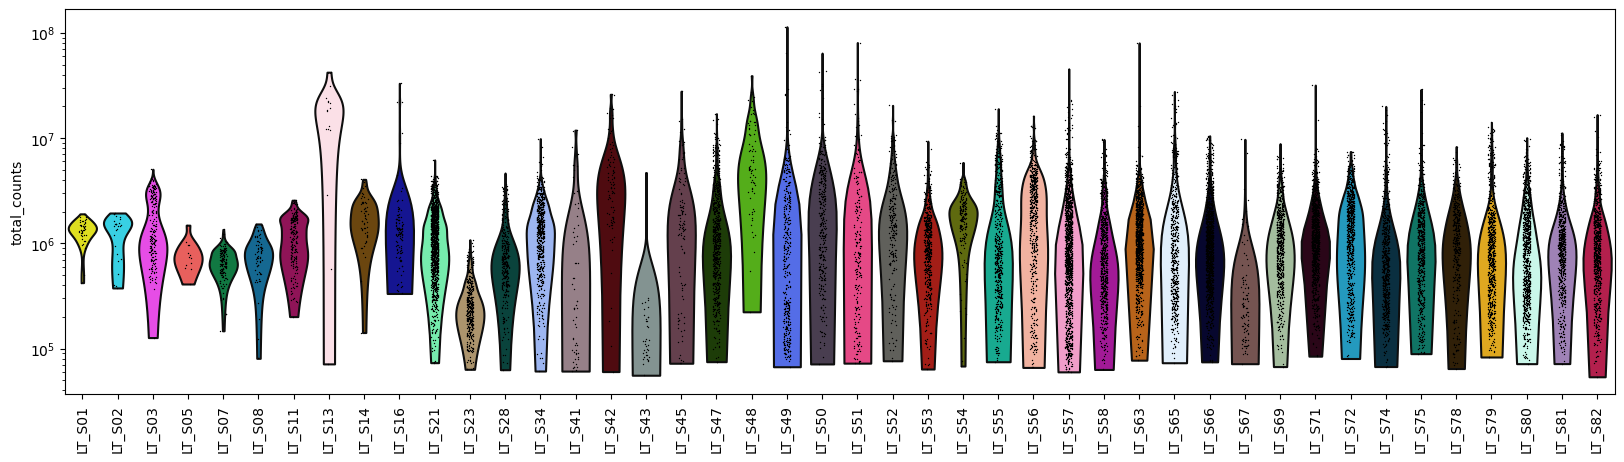

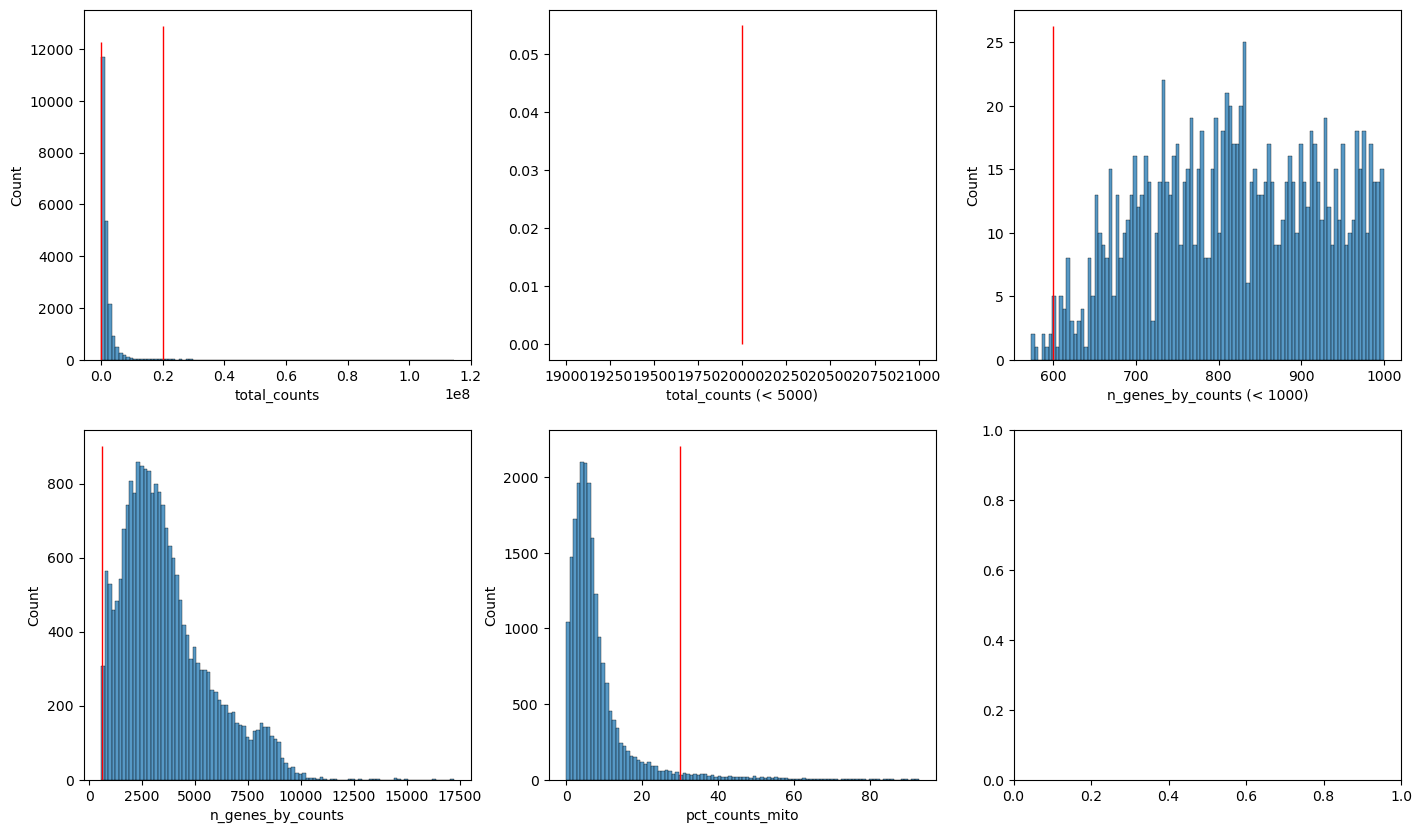

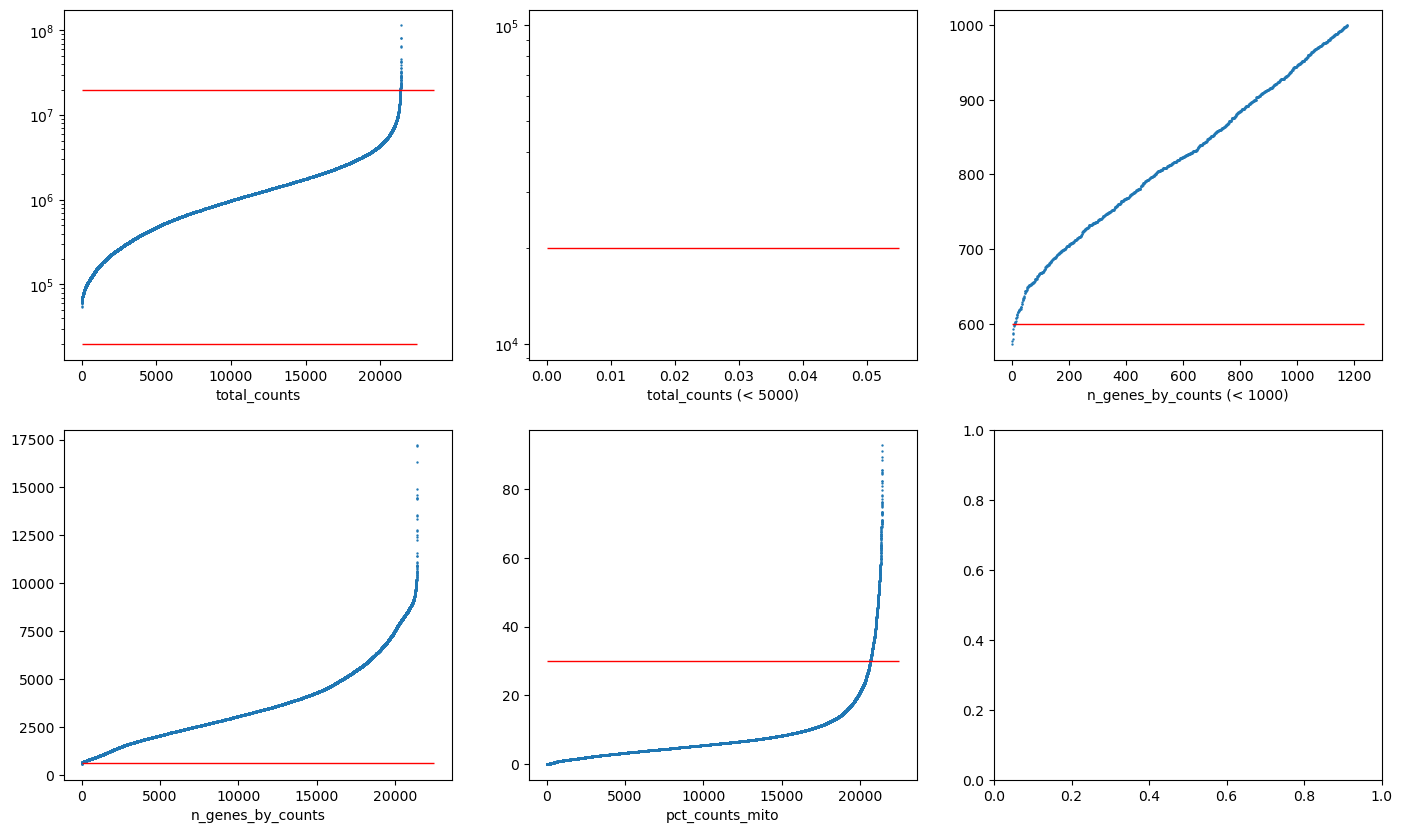

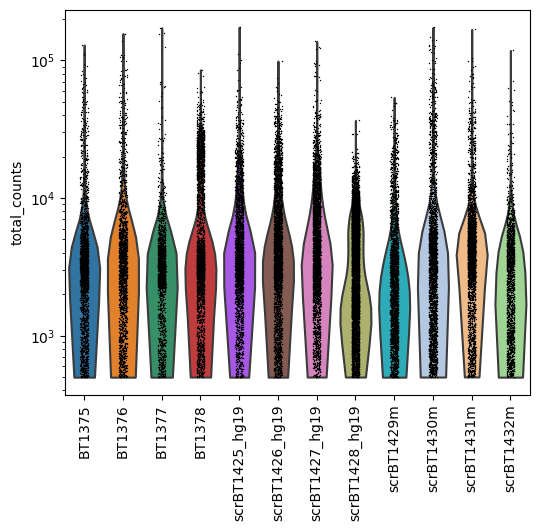

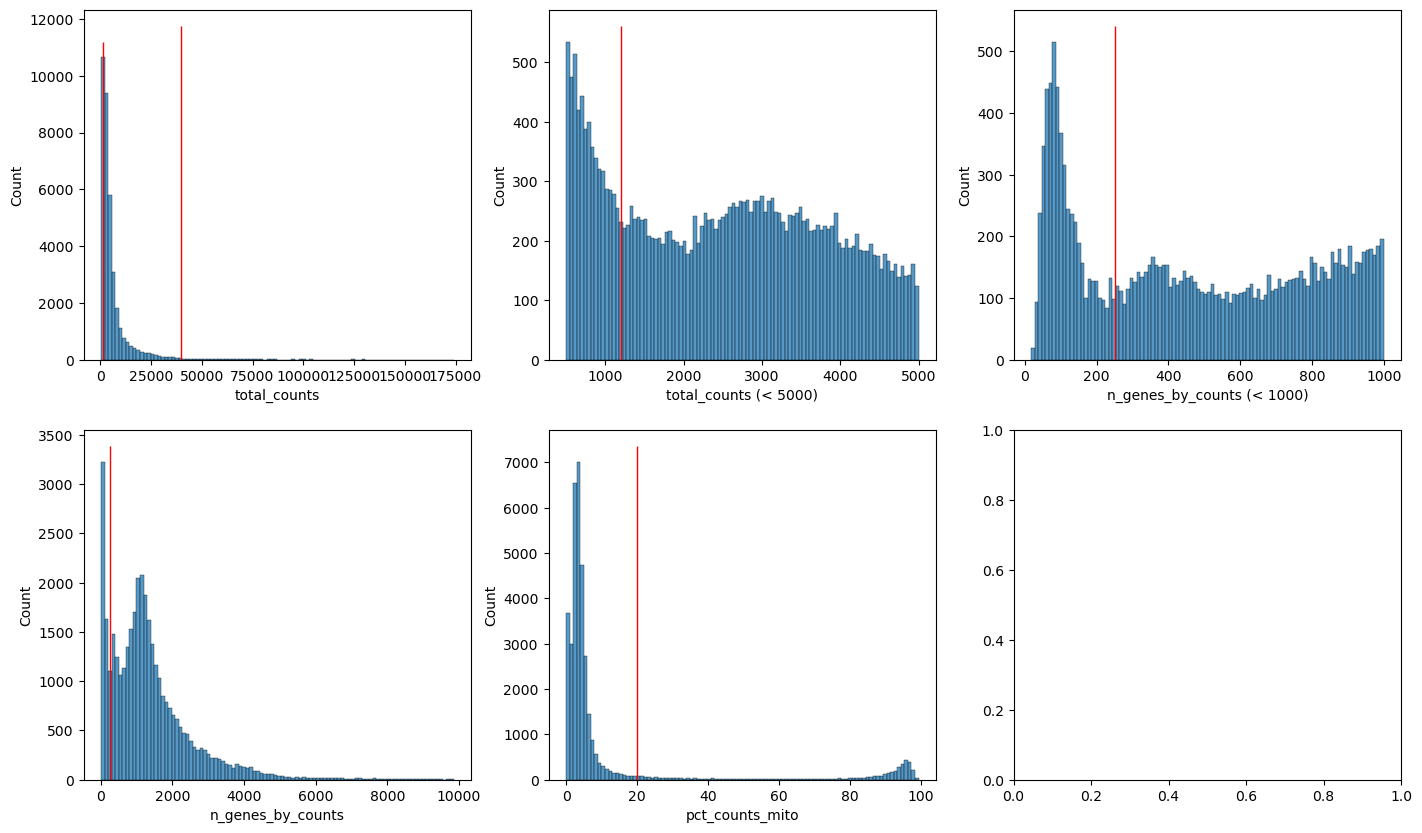

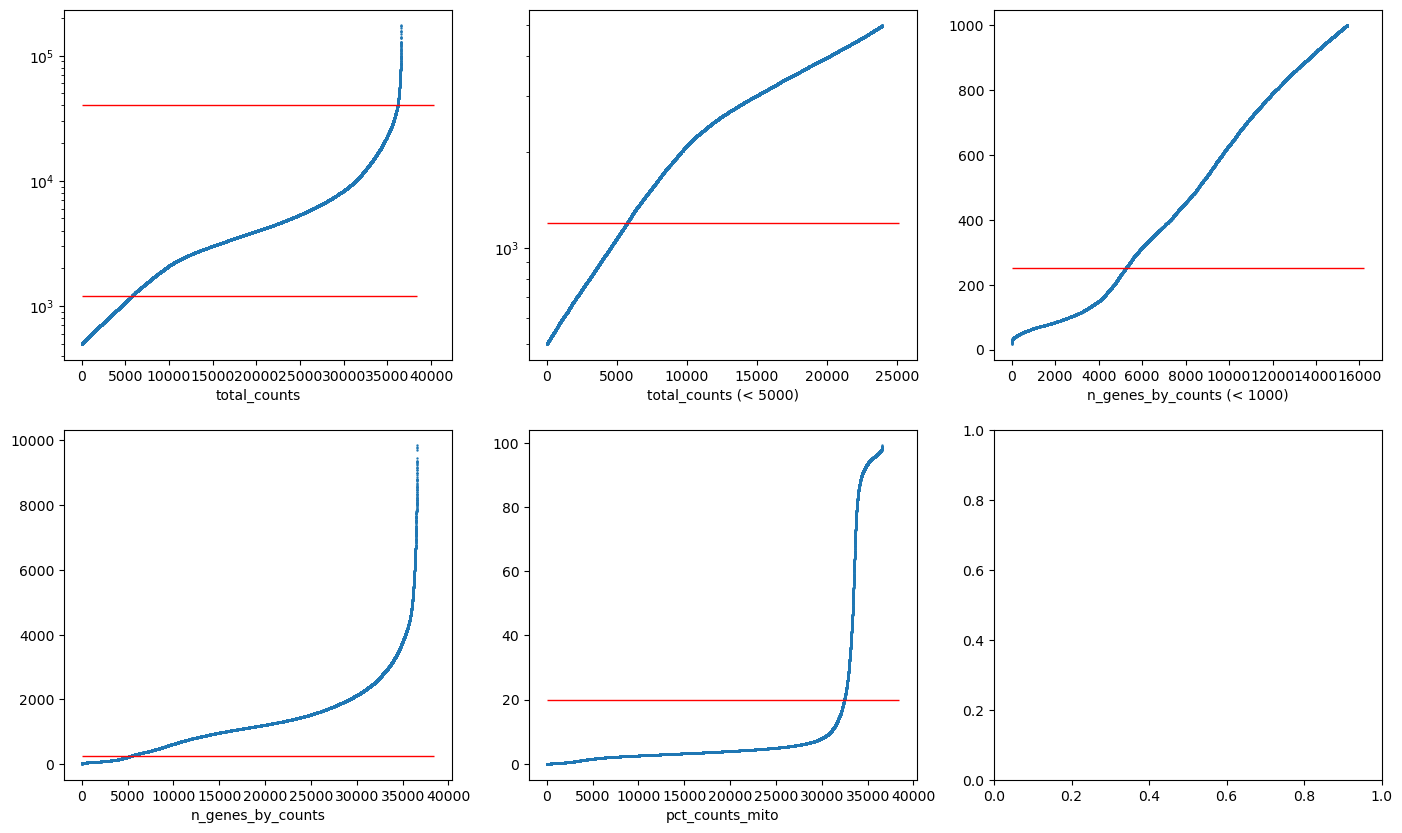

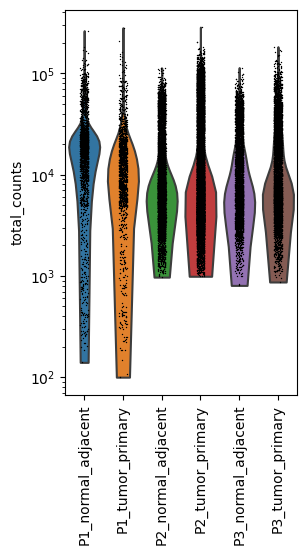

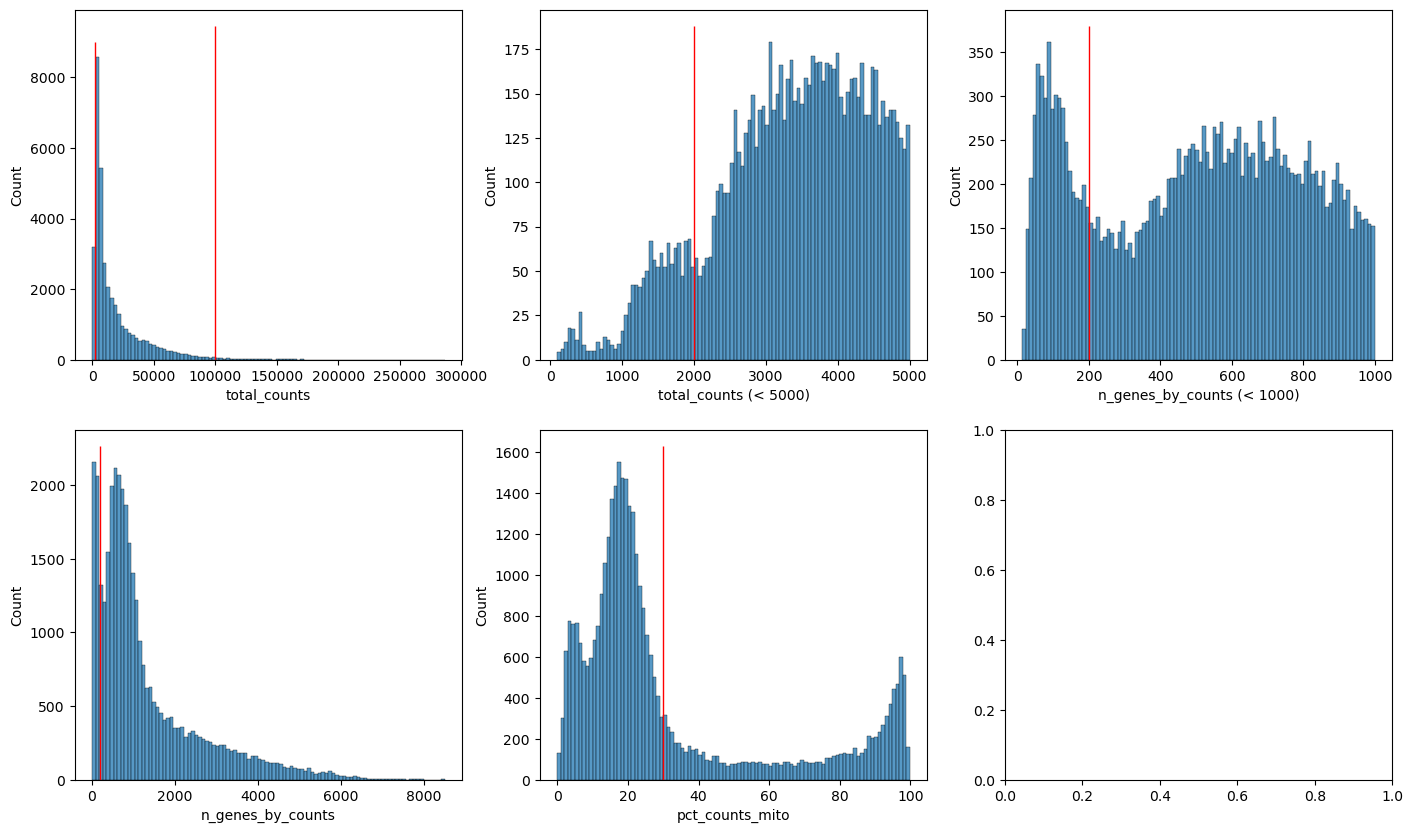

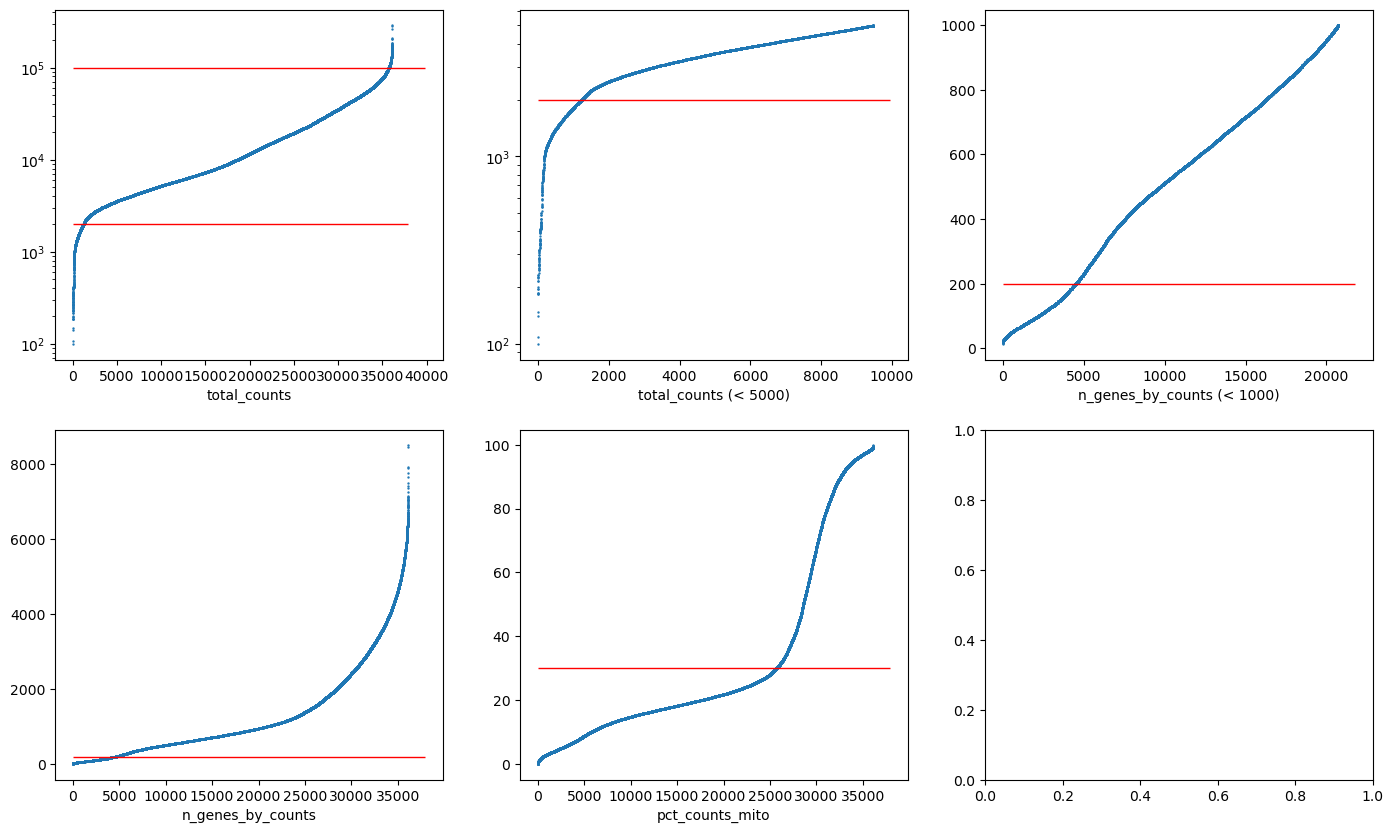

In [22]:
for dataset, thresholds in THRESHOLDS.items():
    display(HTML(f"<h2>{dataset}</h2>"))
    adata = datasets[dataset]
    if "mito" not in adata.var.columns:
        adata.var["mito"] = adata.var_names.str.lower().str.startswith("mt-")
    sc.pp.calculate_qc_metrics(adata, qc_vars=("mito",), log1p=False, inplace=True, percent_top=None)
    figwidth = min(max(adata.obs["sample"].unique().size * 0.5, 2), 20)
    fig, ax = plt.subplots(1, 1, figsize=(figwidth, 5))
    sc.pl.violin(adata, "total_counts", groupby="sample", rotation=90, log=True, cut=0, ax=ax)
    aps.pl.plot_qc_metrics(adata, **thresholds)
    aps.pl.plot_qc_metrics(adata, cumulative=True, **thresholds)